In [169]:
%matplotlib inline

In [170]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from celeriteflow import ops

In [327]:
from multiprocessing import Pool
pool = Pool()

In [328]:
session = tf.Session()

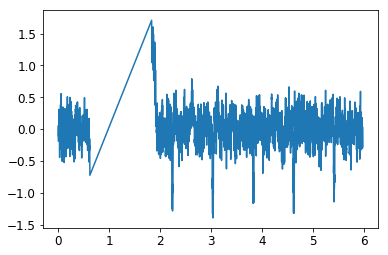

In [329]:
data = np.loadtxt('228754001.dat.ts')

T = tf.float64

t = tf.constant(data[:, 0]*0.0864, dtype=T)
y = tf.constant(data[:, 1:2]*1e3, dtype=T)

log_var = np.log(np.var(data[:,1]*1e3))

plt.plot(*(session.run([t, y])))

In [330]:
log_jitter = tf.Variable(log_var, dtype=T, name="log_jitter")
log_numax = tf.Variable(np.log(250.0), dtype=T, name="log_numax")
log_dnu = tf.Variable(np.log(20.0), dtype=T, name="log_dnu")
gamma = tf.Variable([-1, 0.0, 1], dtype=T, name="gamma")
log_H = tf.Variable([log_var, log_var, log_var], dtype=T, name="log_H")
log_sigma = tf.Variable(np.log(10.0), dtype=T, name="log_sigma")
log_Q = tf.Variable(10., dtype=T, name="log_Q")

numax = tf.exp(log_numax)
nprime = tf.range(-2.0, 3.0, dtype=T)
ell = tf.mod(tf.range(3, dtype=T), 2)
nu = numax + gamma[None, :] + (tf.exp(log_dnu) * (nprime[:, None] + 0.5*ell[None, :]))
log_amp = log_H[None, :] - 0.5*tf.square(nu - numax)*tf.exp(-2*log_sigma)

w0 = 2*np.pi*nu
Q = 1.0 + tf.exp(log_Q)  # Make sure that Q is always greater than 1
Q2 = tf.square(Q)
S0 = tf.exp(log_amp) / Q2

f = tf.sqrt(4.0 * Q2 - 1.0)
nada = tf.constant([], dtype=T)
a = tf.reshape(S0 * w0 * Q, [-1])
b = tf.reshape(S0 * w0 * Q / f, [-1])
c = tf.reshape(0.5 * w0 / Q, [-1])
d = tf.reshape(0.5 * w0 / Q * f, [-1])

# Granulation terms
log_S0_gran = tf.Variable([log_var - 10.0, log_var - 10.0], dtype=T, name="log_S0_gran")
log_w0_gran = tf.Variable(np.log([2*np.pi*100.0, 2*np.pi*150.0]), dtype=T, name="log_w0_gran")

arg1 = tf.exp(log_S0_gran + log_w0_gran)
arg2 = 0.5 * tf.exp(log_w0_gran)
a = tf.concat([arg1, a], 0)
b = tf.concat([arg1, b], 0)
c = tf.concat([arg2, c], 0)
d = tf.concat([arg2, d], 0)

# Power spectrum
freq = tf.placeholder_with_default(
    np.linspace(10, 280, 10000),
    (10000, )
)
omega = 2 * np.pi * freq
num = (a * c + b * d) * (tf.square(c) + tf.square(d)) + (a * c - b * d) * tf.square(omega)[:, None]
denom = (omega**4)[:, None] + 2*(tf.square(c) - tf.square(d)) * tf.square(omega)[:, None] + tf.square(tf.square(c) + tf.square(d)) 
psds = np.sqrt(2.0 / np.pi) * num / denom
psd = tf.reduce_sum(psds, 1)



# GP model
A, U, V, P = ops.get_celerite_matrices(nada, nada, a, b, c, d, t, tf.exp(log_jitter) + tf.zeros_like(t))
D, W = ops.celerite_factor(A, U, V, P)
z = ops.celerite_solve(U, P, D, W, y)

chi2 = tf.squeeze(tf.matmul(y, z, transpose_a=True)) + tf.reduce_sum(tf.log(D))
log_prob = -0.5*chi2

session.run(tf.global_variables_initializer())
print(session.run(chi2))
session.run(tf.gradients(chi2, [log_S0_gran, log_w0_gran]))

-3513.320979953144


[array([-70.15621612, -50.95047635]), array([ 8.23357248, 30.53920965])]

In [331]:
ids = np.concatenate((
    np.zeros(2),
    np.arange(1, 4),
    np.arange(1, 4),
    np.arange(1, 4),
    np.arange(1, 4),
    np.arange(1, 4),
)).astype(int)
colors = np.array(["k", "b", "g", "r"])[ids]

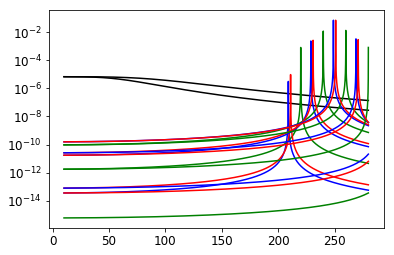

In [332]:
x, ys = session.run([freq, psds])
for a, b in zip(ys.T, colors):
    plt.semilogy(x, a, color=b)

In [333]:
def gridsearch(session,target,var,grid,index=0):
    target_grid = np.empty_like(grid)
    var_init = session.run(var)
    shape = np.shape(var_init)
    var_init = np.atleast_1d(var_init)
    for i, value in enumerate(grid):
        var_init[index] = value
        target_grid[i] = session.run(target, feed_dict={var: np.reshape(var_init, shape)})
    var_init[index] = grid[np.argmin(target_grid)]
    session.run(tf.assign(var, np.reshape(var_init, shape)))
    return target_grid

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -5284.975116
  Number of iterations: 2
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -5284.975116
  Number of iterations: 2
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -5301.042690
  Number of iterations: 33
  Number of functions evaluations: 75


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -5301.042690
  Number of iterations: 33
  Number of functions evaluations: 75


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -5311.432217
  Number of iterations: 58
  Number of functions evaluations: 89


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -5311.432217
  Number of iterations: 58
  Number of functions evaluations: 89


[array([-7.08081716, -9.58794227]), array([3.99235592, 6.0438307 ]), 3.767074540665115, 12.916869220472261, array([-3.3284784 , -3.14863712, -3.03924895]), -3.722319934663601, array([-3.83706751, -0.67014309,  0.51865004]), 5.599460367134415, 3.0033858703317153]


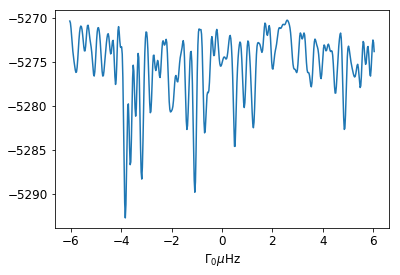

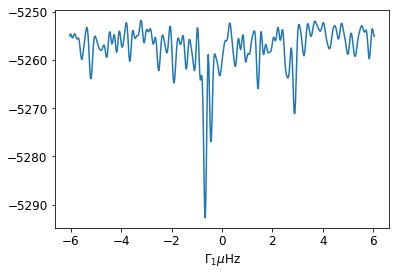

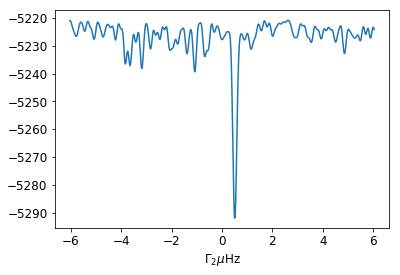

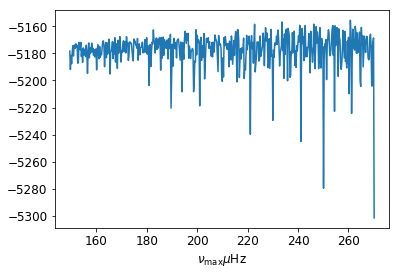

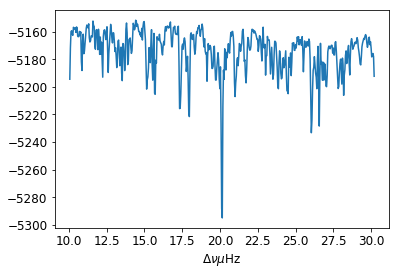

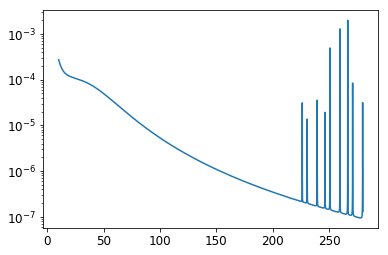

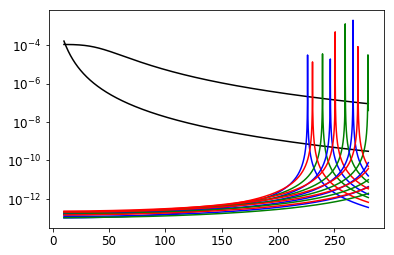

In [335]:
#proposed schedule: 0. inititialize vars, 1.optimize gran params, 2.gridsearch gamma, 3. opt all but numax/dnu, 4. grid numax/dnu, 5. optimize all params, 6. return to 2

def optimize(variables):
    opt = tf.contrib.opt.ScipyOptimizerInterface(chi2, var_list=variables)
    opt.minimize(session)

granvariables = [log_S0_gran, log_w0_gran]#, log_numax, log_sigma, log_Q, log_H, log_jitter] 

optimize(granvariables)

dn = session.run(log_dnu)
grid = np.linspace(-0.3*np.exp(dn),0.3*np.exp(dn), 500)

chi2_grid = gridsearch(session,chi2,gamma,grid,0)
plt.plot(grid, chi2_grid)
plt.xlabel(r'$\Gamma_0 \mu$Hz')
plt.figure()
chi2_grid = gridsearch(session,chi2,gamma,grid,1)
plt.plot(grid, chi2_grid)
plt.xlabel(r'$\Gamma_1 \mu$Hz')
plt.figure()
chi2_grid = gridsearch(session,chi2,gamma,grid,2)
plt.plot(grid, chi2_grid)
plt.xlabel(r'$\Gamma_2 \mu$Hz')



mostvars = granvariables + [log_sigma, log_Q, log_H, log_jitter, gamma]

optimize(mostvars)

val0, dn = session.run([log_numax, log_dnu])
grid = np.log(np.exp(val0) + np.linspace(-3*np.exp(dn),3*np.exp(dn), 500))
chi2_grid = gridsearch(session,chi2,log_numax,grid)
plt.figure()
plt.plot(np.exp(grid), chi2_grid)
plt.xlabel(r'$\nu_\mathrm{max} \mu$Hz')

dn = session.run(log_dnu)
grid = np.log(np.linspace(-0.5*np.exp(dn),0.5*np.exp(dn), 500)+np.exp(dn))
chi2_grid = gridsearch(session,chi2,log_dnu,grid)
plt.figure()
plt.plot(np.exp(grid), chi2_grid)
plt.xlabel(r'$\Delta\nu \mu$Hz')


allvars = mostvars + [log_numax, log_dnu]

optimize(allvars)

plt.figure()
plt.semilogy(*session.run([freq, psd]))

plt.figure()
x, ys = session.run([freq, psds])
for a, b in zip(ys.T, colors):
    plt.semilogy(x, a, color=b)
    
print(session.run(allvars))

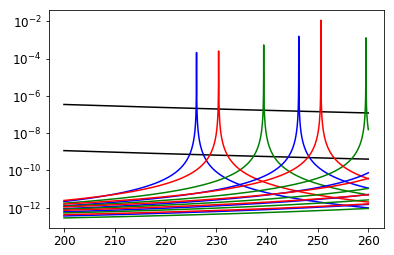

In [342]:
# plt.semilogy(*session.run([freq, psd], feed_dict={freq: np.linspace(200, 300, 10000)}))
x, ys = session.run([freq, psds], feed_dict={freq: np.linspace(200, 260, 10000)})
for a, b in zip(ys.T, colors):
    plt.semilogy(x, a, color=b)

(0.0003, 0.01)

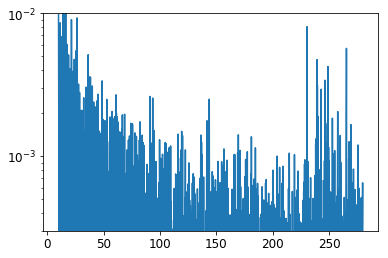

In [314]:
from astropy.stats import LombScargle
freq_muHz = np.linspace(10, 280, 10000)

model = LombScargle(*session.run([t, y[:, 0]]))
power = model.power(session.run(freq))
plt.semilogy(session.run(freq), power)
plt.ylim(3e-4,1e-2)

In [343]:
import emcee
var_list = [log_S0_gran, log_w0_gran, log_sigma, log_Q, log_H, log_jitter, gamma, log_numax, log_dnu]
initial_vars = session.run(var_list)
sizes = [np.size(v) for v in initial_vars]
shapes = [np.shape(v) for v in initial_vars]
names = []
for var, size in zip(var_list, sizes):
    if size > 1:
        for i in range(size):
            names.append(var.name[:-2] + "{0}".format(i+1))
    else:
        names.append(var.name[:-2])

In [345]:
def get_feed_dict(vector):
    i = 0
    feed_dict = {}
    for var, size, shape in zip(var_list, sizes, shapes):
        feed_dict[var] = np.reshape(vector[i:i+size], shape)
        i += size
    return feed_dict

def emcee_log_prob(vector):
    if np.any(vector < -15) or np.any(vector > 15):
        return -np.inf
    return session.run(log_prob, feed_dict=get_feed_dict(vector))

p0 = np.concatenate([np.reshape(v, -1) for v in initial_vars])
p0 = p0 + 1e-5 * np.random.randn(30, len(p0))
nwalkers, ndim = p0.shape
emcee_sampler = emcee.EnsembleSampler(nwalkers, ndim, emcee_log_prob)
pos, _, _ = emcee_sampler.run_mcmc(p0, 1000);

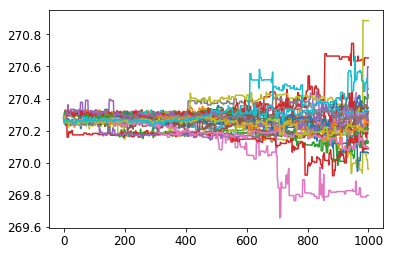

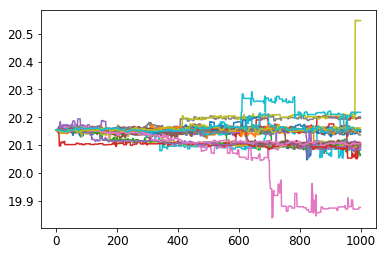

In [346]:
plt.plot(np.exp(emcee_sampler.chain[:, :, -2].T));
plt.show()
plt.clf()
plt.plot(np.exp(emcee_sampler.chain[:, :, -1].T));

In [ ]:
best_pars_so_far = emcee_sampler.flatchain[np.argmax(emcee_sampler.flatlnprobability)]

p0 = [best_pars_so_far *(1+ 1e-3*np.random.randn(ndim)) for i in range(nwalkers)]
pos, _, _ = emcee_sampler.run_mcmc(p0, 2000);

In [ ]:
plt.plot(np.exp(emcee_sampler.chain[:, :, -2].T));
plt.show()
plt.clf()
plt.plot(np.exp(emcee_sampler.chain[:, :, -1].T));

In [ ]:
burnin = 300
samples = emcee_sampler.chain[:, burnin:, :].reshape((-1, ndim))

[log_S00_mcmc, log_omega00_mcmc, log_S01_mcmc, log_omega01_mcmc, log_sigma_mcmc, log_Q0_mcmc, log_H0_mcmc, log_H1_mcmc, log_H2_mcmc, \
    log_jit, gamma0_mcmc, gamma1_mcmc, gamma2_mcmc, log_numax_mcmc, log_dnu_mcmc] = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                            zip(*np.percentile(samples, [16, 50, 84], axis=0))) 
print("""MCMC result:
log_S0,0 = {0[0]} +{0[1]} -{0[2]} 
log_omega0,0 = {1[0]} +{1[1]} -{1[2]}
log_S0,1 = {2[0]} +{2[1]} -{2[2]} 
log_omega0,1 = {3[0]} +{3[1]} -{3[2]}
log_sigma = {4[0]} +{4[1]} -{4[2]} 
log_Q0 = {5[0]} +{5[1]} -{5[2]}
log_H0 = {6[0]} +{6[1]} -{6[2]} 
log_H1 = {7[0]} +{7[1]} -{7[2]}
log_H2 = {8[0]} +{8[1]} -{8[2]}
log_jit = {9[0]} +{9[1]} -{9[2]} 
gamma0 = {10[0]} +{10[1]} -{10[2]}
gamma1 = {11[0]} +{11[1]} -{11[2]}
gamma2 = {12[0]} +{12[1]} -{12[2]}
log_numax = {13[0]} +{13[1]} -{13[2]}
log_dnu = {14[0]} +{14[1]} -{14[2]}
""".format(log_S00_mcmc, log_omega00_mcmc, log_S01_mcmc, log_omega01_mcmc, log_sigma_mcmc, log_Q0_mcmc, log_H0_mcmc, \
           log_H1_mcmc, log_H2_mcmc, log_jit, gamma0_mcmc, gamma1_mcmc, gamma2_mcmc, log_numax_mcmc, log_dnu_mcmc)) 
#lnper = {8[0]} +{8[1]} -{8[2]} 

print("Mean acceptance fraction: {0:.3f}"
        .format(np.mean(emcee_sampler.acceptance_fraction)))

In [ ]:
numax, dnu = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                            zip(*np.percentile(np.exp(samples[:,-2:]), [16, 50, 84], axis=0)))
print(numax, dnu)

In [ ]:
samples = emcee_sampler.chain[:, burnin:, :].reshape((-1, ndim))
sampler = emcee_sampler
from matplotlib.ticker import MaxNLocator

plt.clf()
fig, axes = plt.subplots(len(samples[0]), 1, sharex=True, figsize=(20, 20))
axes[0].plot((sampler.chain[:, :, 0].T), color="k", alpha=0.4)
axes[0].yaxis.set_major_locator(MaxNLocator(5))
axes[0].axhline(np.median(sampler.chain[:, :, 0].T), color="#888888", lw=2)
axes[0].set_ylabel(r"ln_numax")
    
axes[1].plot((sampler.chain[:, :, 1].T), color="k", alpha=0.4)
axes[1].yaxis.set_major_locator(MaxNLocator(5))
axes[1].axhline(np.median(sampler.chain[:, :, 1].T), color="#888888", lw=2)
axes[1].set_ylabel(r"ln_dnu")

axes[2].plot((sampler.chain[:, :, 2].T), color="k", alpha=0.4)
axes[2].yaxis.set_major_locator(MaxNLocator(5))
axes[2].axhline(np.median(sampler.chain[:, :, 2].T), color="#888888", lw=2)
axes[2].set_ylabel(r"gamma0")
    
axes[3].plot((sampler.chain[:, :, 3].T), color="k", alpha=0.4)
axes[3].yaxis.set_major_locator(MaxNLocator(5))
axes[3].axhline(np.median(sampler.chain[:, :, 3].T), color="#888888", lw=2)
axes[3].set_ylabel(r"gamma1")

axes[4].plot((sampler.chain[:, :, 4].T), color="k", alpha=0.4)
axes[4].yaxis.set_major_locator(MaxNLocator(5))
axes[4].axhline(np.median(sampler.chain[:, :, 4].T), color="#888888", lw=2)
axes[4].set_ylabel(r"logH0")

axes[5].plot((sampler.chain[:, :, 5].T), color="k", alpha=0.4)
axes[5].yaxis.set_major_locator(MaxNLocator(5))
axes[5].axhline(np.median(sampler.chain[:, :, 5].T), color="#888888", lw=2)
axes[5].set_ylabel(r"logH1")

axes[6].plot((sampler.chain[:, :, 6].T), color="k", alpha=0.4)
axes[6].yaxis.set_major_locator(MaxNLocator(5))
axes[6].axhline(np.median(sampler.chain[:, :, 6].T), color="#888888", lw=2)
axes[6].set_ylabel(r"log_sigma")

axes[7].plot((sampler.chain[:, :, 7].T), color="k", alpha=0.4)
axes[7].yaxis.set_major_locator(MaxNLocator(5))
axes[7].axhline(np.median(sampler.chain[:, :, 7].T), color="#888888", lw=2)
axes[7].set_ylabel(r"log_Q0")

axes[8].plot((sampler.chain[:, :, 8].T), color="k", alpha=0.4)
axes[8].yaxis.set_major_locator(MaxNLocator(5))
axes[8].axhline(np.median(sampler.chain[:, :, 8].T), color="#888888", lw=2)
axes[8].set_ylabel(r"log_S0,0")

axes[9].plot((sampler.chain[:, :, 9].T), color="k", alpha=0.4)
axes[9].yaxis.set_major_locator(MaxNLocator(5))
axes[9].axhline(np.median(sampler.chain[:, :, 9].T), color="#888888", lw=2)
axes[9].set_ylabel(r"log_omega0,0")

axes[10].plot((sampler.chain[:, :, 10].T), color="k", alpha=0.4)
axes[10].yaxis.set_major_locator(MaxNLocator(5))
axes[10].axhline(np.median(sampler.chain[:, :, 10].T), color="#888888", lw=2)
axes[10].set_ylabel(r"logS01")

axes[11].plot((sampler.chain[:, :, 11].T), color="k", alpha=0.4)
axes[11].yaxis.set_major_locator(MaxNLocator(5))
axes[11].axhline(np.median(sampler.chain[:, :, 11].T), color="#888888", lw=2)
axes[11].set_ylabel(r"logomega0,1")

axes[12].plot((sampler.chain[:, :, 12].T), color="k", alpha=0.4)
axes[12].yaxis.set_major_locator(MaxNLocator(5))
axes[12].axhline(np.median(sampler.chain[:, :, 12].T), color="#888888", lw=2)
axes[12].set_ylabel(r"log_whitenoise")

axes[13].plot((sampler.chain[:, :, 13].T), color="k", alpha=0.4)
axes[13].yaxis.set_major_locator(MaxNLocator(5))
axes[13].axhline(np.median(sampler.chain[:, :, 13].T), color="#888888", lw=2)
axes[13].set_ylabel(r"log_numax")

axes[14].plot((sampler.chain[:, :, 14].T), color="k", alpha=0.4)
axes[14].yaxis.set_major_locator(MaxNLocator(5))
axes[14].axhline(np.median(sampler.chain[:, :, 14].T), color="#888888", lw=2)
axes[14].set_ylabel(r"log_dnu")


import corner
from matplotlib.ticker import MultipleLocator, FormatStrFormatter


majorFormatter = FormatStrFormatter('%.2f')
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(majorFormatter)

plt.clf()
plt.rcParams["font.size"] = 12
#plt.rcParams["font.family"] = "sans-serif"
#plt.rcParams["font.sans-serif"] = ["Computer Modern Sans"]
#plt.rcParams["text.usetex"] = True
#plt. rcParams["text.latex.preamble"] = r"\usepackage{cmbright}"
#plt.rcParams['font.size']=18  
fig = corner.corner(samples, labels=[r"lnS00", r"lnomega00", r"gamma0", r"gamma1", r"gamma2", r"lnH0", r"lnH1", r"lnH2", r"ln_sigma",\
                                     r"lnQ0",  r"lnS01", r"lnomega01", "log_jit", r"lnnumax", r"lndnu"], quantiles=[0.16, 0.5, 0.84],
                      truths=[np.median(sampler.chain[:, :, 0].T), np.median(sampler.chain[:, :, 1].T), np.median(sampler.chain[:, :, 2].T), \
                              np.median(sampler.chain[:, :, 3].T), np.median(sampler.chain[:, :, 4].T), np.median(sampler.chain[:, :, 5].T), \
                              np.median(sampler.chain[:, :, 6].T), np.median(sampler.chain[:, :, 7].T), np.median(sampler.chain[:, :, 8].T), \
                              np.median(sampler.chain[:, :, 9].T), np.median(sampler.chain[:, :, 10].T), np.median(sampler.chain[:, :, 11].T), \
                              np.median(sampler.chain[:, :, 12].T), np.median(sampler.chain[:, :, 13].T), np.median(sampler.chain[:, :, 14].T),])
    
fig.tight_layout()


In [ ]:
sampler.chain.shape

In [ ]:
samples = sampler.chain[:, 1000:, :].reshape(-1, sampler.chain.shape[-1])

for s in samples[np.random.randint(len(samples), size=50)]:
    plt.semilogy(*session.run([freq, psd], feed_dict=get_feed_dict(s)), color="k", alpha=0.3)